In [68]:
import re
# nltk.download('vader_lexicon')
import pandas as pd
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
pd.options.mode.chained_assignment = None
import string
from datetime import datetime
from database import TweetDB
%matplotlib inline

* data preparing

In [69]:
# connect to the sqlite3 db file, utilizing the customized module
tweetdb = TweetDB()
engine = tweetdb.get_engine()
conn = engine.connect()

In [70]:
df = pd.read_sql('select * from tweets', conn)

In [71]:
# twitter text processing and cleaning function
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [72]:
df['tweet_clean'] = df['tweet'].apply(lambda t: process_words(t, remove_punc=True))

In [73]:
# transform tweet timestamp from string format to datetime
df['date'] = df['timestamp'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df['date'] = df['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))

In [74]:
# subset the recent tweets
recent = df[df['date']>=datetime(2019,1,1)]

In [75]:
recent['author'].unique()

array(['IBDinvestors', 'CapEconCanada', 'CapEconMarkets', 'WSJmarkets',
       'globebusiness', 'financialpost', 'barronsonline', 'BNNBloomberg',
       'WSJ', 'TheEconomist', 'YahooFinance', 'MarketWatch', 'FT', 'CNBC',
       'business', 'SeekingAlpha'], dtype=object)

* Exploratory Analysis

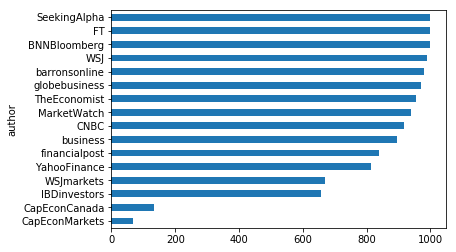

In [76]:
# count the number recent tweets collected from each news outlet
tweetcount = recent.groupby('author')['tweet'].count().sort_values().plot(kind='barh')

In [77]:
analyzer = SentimentIntensityAnalyzer()

In [78]:
analyzer.polarity_scores(r'I\'m really good')

{'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'compound': 0.4927}

In [79]:
recent['sentiment'] = recent['tweet'].apply(lambda t: analyzer.polarity_scores(t)['compound'])

In [80]:
focus = recent[['author','date','tweet','sentiment']]

In [81]:
focus = focus.sort_values(by='sentiment')

In [82]:
# highest 5 and lowest 5 sentiment score
focus.head(5).append(sorted.tail(5))

,author,date,tweet,sentiment
11108,business,2019-05-02,California man who Tesla accused of spying and...,-0.9623
7594,TheEconomist,2019-04-28,It is not unusual for Indian politicians to st...,-0.9545
13673,TheEconomist,2019-05-03,"For years, YouTube avoided the type of ire dir...",-0.9337
14448,WSJ,2019-05-03,"A terror attack in San Bernardino, Calif., fea...",-0.9295
8813,WSJ,2019-04-30,At least one suicide bomber in the Easter atta...,-0.9287
9882,CNBC,2019-05-01,"With so many credit cards to choose from, it c...",0.9322
11768,WSJ,2019-05-02,U.S. workers’ efficiency improved during the p...,0.9325
14267,CNBC,2019-05-03,We're proud to announce the winners of our #Sa...,0.9442
14356,YahooFinance,2019-05-03,Highlight: @seescandies CEO Pat Egan on traits...,0.9511
6245,YahooFinance,2019-04-25,Highlight: “I love to see a market like this w...,0.9628


In [83]:
# average sentiment score
focus['sentiment'].mean()

0.0482121696421595